# General imports

In [1]:
import numpy as np

from multiview_prediction_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_prediction_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_prediction_toolkit.config import DATA_FOLDER

from multiview_prediction_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)

from multiview_prediction_toolkit.config import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_PREDICTED_VECTOR_LABELS_FILE,
    EXAMPLE_LABEL_NAMES,
)

2023-11-14 16:52:27:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmp_4d_t4ms


# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = True
# Processing parameters
# Something is off about the elevation between the mesh and the DTM, this should be a threshold in meters above ground
HEIGHT_ABOVE_GROUND_THRESH = 34666.83516999893 + 5
MESH_DOWNSAMPLE_TARGET = 0.25  # Downsample the mesh to this fraction
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution
BUFFER_RADIUS_METER = 50  # Include cameras within this radius of labeled points

CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
MESH_FILENAME = EXAMPLE_MESH_FILENAME
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
PREDICTED_IMAGE_LABELS_FOLDER = EXAMPLE_PREDICTED_LABELS_FOLDER
DTM_FILE = EXAMPLE_DTM_FILE
AGGREGATED_FACE_LABELS_FILE = EXAMPLE_AGGREGATED_FACE_LABELS_FILE
LABEL_NAMES = EXAMPLE_LABEL_NAMES
PREDICTED_VECTOR_LABELS_FILE = EXAMPLE_PREDICTED_VECTOR_LABELS_FILE

# Load the mesh

In [3]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME, transform_filename=EXAMPLE_CAMERAS_FILENAME
)

# Load the camera set and subsample

In [4]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_near_geofile(
    LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

Loading GPS data for camera set: 100%|██████████| 915/915 [00:08<00:00, 109.44it/s]


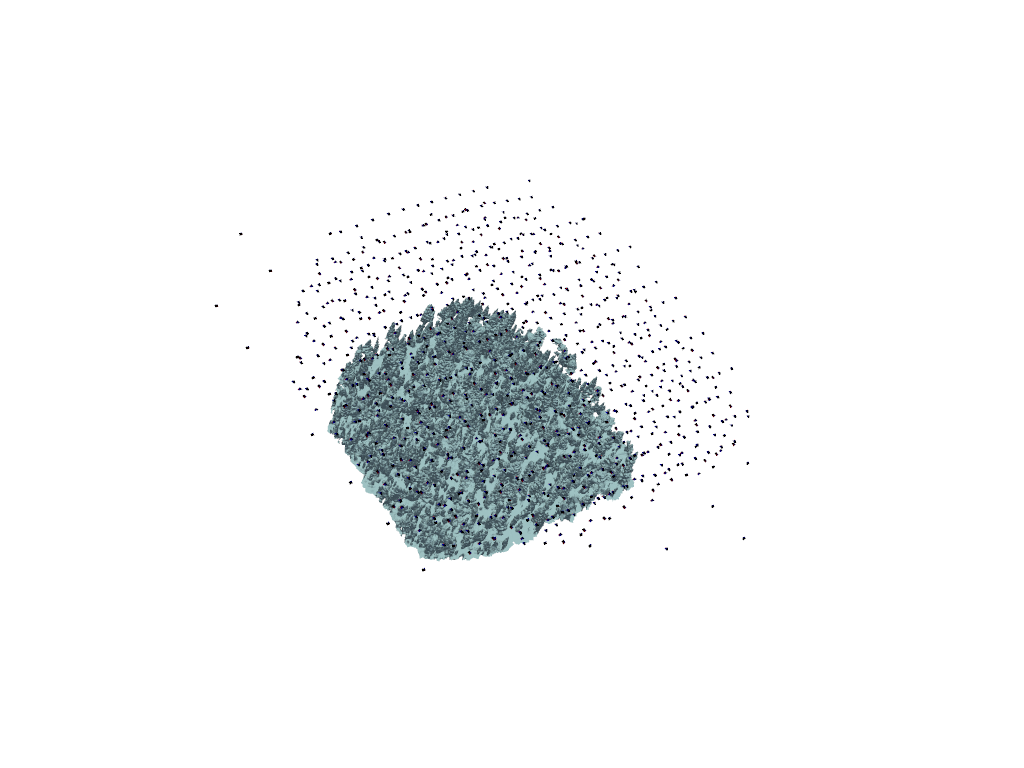

In [5]:
mesh.vis(camera_set=camera_set, force_xvfb=True)

In [6]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(LABEL_NAMES),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

In [7]:
if USE_CACHED_AGGREGATION:
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _, _ = mesh.aggregate_viewpoints_pytorch3d(
        segmentor_camera_set,
        image_scale=AGGREGATE_IMAGE_SCALE,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

In [8]:
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
# Compute which vertices are part of the ground by thresholding the height above the DTM
ground_mask_verts = mesh.get_height_above_ground(
    DTM_file=DTM_FILE, threshold=HEIGHT_ABOVE_GROUND_THRESH
)
ground_mask_faces = mesh.vert_to_face_texture(ground_mask_verts.astype(int)).astype(
    bool
)
predicted_face_classes[ground_mask_faces] = np.nan

Sampling values from raster: 100%|██████████| 705768/705768 [00:01<00:00, 663012.93it/s]


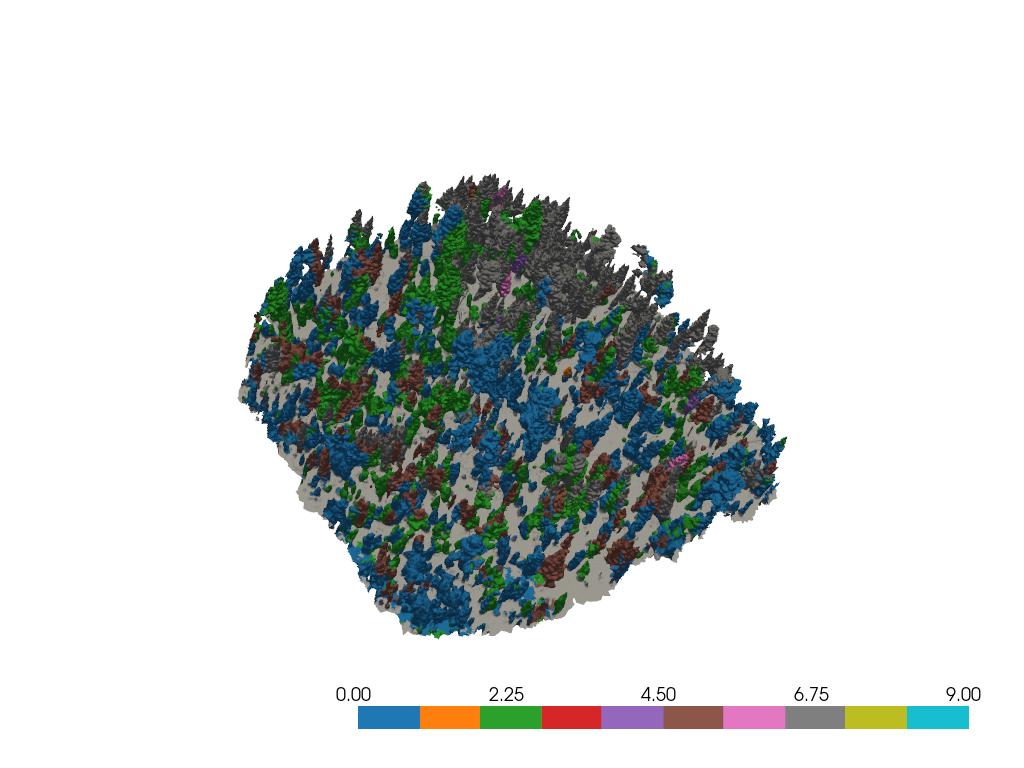

In [9]:
mesh.vis(vis_scalars=predicted_face_classes)

# Export the prediction to a vector file

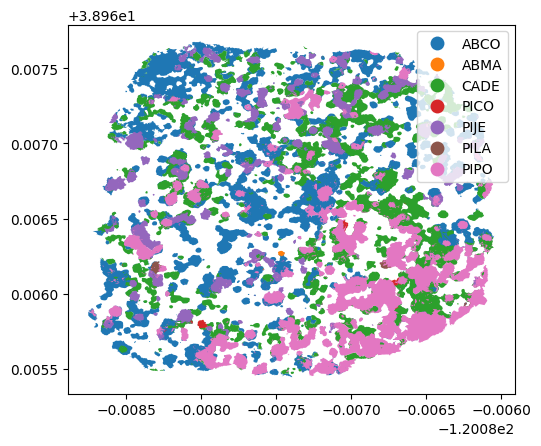

,class_id,geometry,names
0,0.0,"MULTIPOLYGON (((-120.08867 38.96577, -120.0886...",ABCO
1,1.0,"MULTIPOLYGON (((-120.08758 38.96616, -120.0875...",ABMA
2,2.0,"MULTIPOLYGON (((-120.08866 38.96575, -120.0886...",CADE
3,4.0,"MULTIPOLYGON (((-120.08811 38.96573, -120.0881...",PICO
4,5.0,"MULTIPOLYGON (((-120.08863 38.96577, -120.0886...",PIJE
5,6.0,"MULTIPOLYGON (((-120.08830 38.96612, -120.0883...",PILA
6,7.0,"MULTIPOLYGON (((-120.08863 38.96579, -120.0886...",PIPO


In [10]:
mesh.export_face_labels_vector(
    face_labels=np.squeeze(predicted_face_classes),
    export_file=PREDICTED_VECTOR_LABELS_FILE,
    label_names=EXAMPLE_LABEL_NAMES,
    vis=True,
    vis_kwargs={"cmap": "tab10", "vmin": 0, "vmax": 9}
)

# Compare the quality of the prediction with the ground truth

In [11]:
from multiview_prediction_toolkit.utils.geospatial import (
    ensure_geometric_CRS,
    get_fractional_overlap,
)
from multiview_prediction_toolkit.utils.prediction_metrics import compute_and_show_cf

result, overlay, labeled_tree_data = get_fractional_overlap(
    species_gt_data, species_pred_data
)

ImportError: cannot import name 'get_fractional_overlap' from 'multiview_prediction_toolkit.utils.geospatial' (/ofo-share/repos-david/semantic-mesh-pytorch3d/multiview_prediction_toolkit/utils/geospatial.py)